In [ ]:
import torch
import torch.nn.functional as F
import torchvision
from torch import nn, optim
from torchvision import transforms, datasets

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

In [ ]:
EPOCH=10
BATCH_SIZE=64
USE_CUDA = torch.cuda.is_available()
DEVICE=torch.device("cuda" if USE_CUDA else "cpu")
print("USE DEVICE : ", DEVICE) 

USE DEVICE :  cpu


In [ ]:
trainset=datasets.FashionMNIST(
    root="./.data/.",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

train_loader=torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder=nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )

        self.decoder=nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return encoded, decoded

In [ ]:
autoencoder=AutoEncoder().to(DEVICE)
optimizer=torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion=nn.MSELoss()

In [ ]:
view_data=trainset.data[:5].view(-1, 28*28)
view_data=view_data.type(torch.FloatTensor)/255.

In [ ]:
def train(autoencoder, train_loader):
    autoencoder.train()
    for step, (x, label) in enumerate(train_loader):
        x=x.view(-1, 28*28).to(DEVICE)
        y=x.view(-1, 28*28).to(DEVICE)
        label=label.to(DEVICE)

        encoded, decoded=autoencoder(x)

        loss=criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[EPOCH 1]


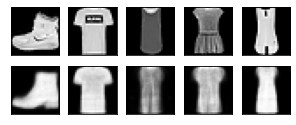

[EPOCH 2]


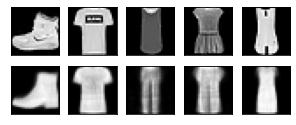

[EPOCH 3]


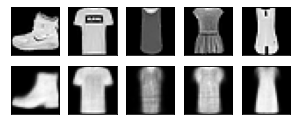

[EPOCH 4]


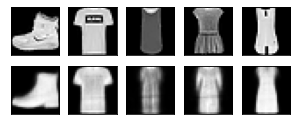

[EPOCH 5]


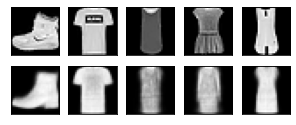

[EPOCH 6]


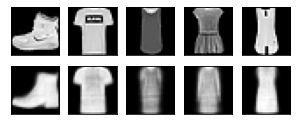

[EPOCH 7]


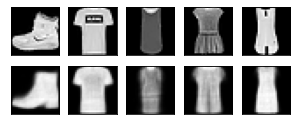

[EPOCH 8]


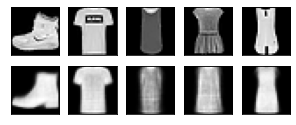

[EPOCH 9]


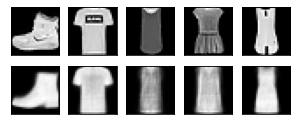

[EPOCH 10]


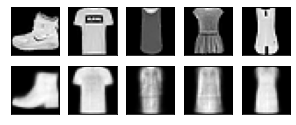

In [ ]:
for epoch in range(1,EPOCH+1):
    train(autoencoder, train_loader)

    test_x=view_data.to(DEVICE)
    _, decoded_data=autoencoder(test_x)

    f,a=plt.subplots(2,5,figsize=(5,2))
    print("[EPOCH {}]".format(epoch))

    for i in range(5):
        img=np.reshape(view_data.data.numpy()[i],(28,28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())

    for i in range(5):
        img=np.reshape(decoded_data.to("cpu").data.numpy()[i], (28,28))
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())

    plt.show()

In [ ]:
#autoencoder의 encoded 값을 가져옴
view_data=trainset.data[:200].view(-1,28*28)
view_data=view_data.type(torch.FloatTensor)/255.
test_x=view_data.to(DEVICE)
encoded_data, _=autoencoder(test_x)
encoded_data=encoded_data.to("cpu")

In [ ]:
CLASSES={
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Snearker',
    8: 'Bag',
    9: 'Ankle boot'
}

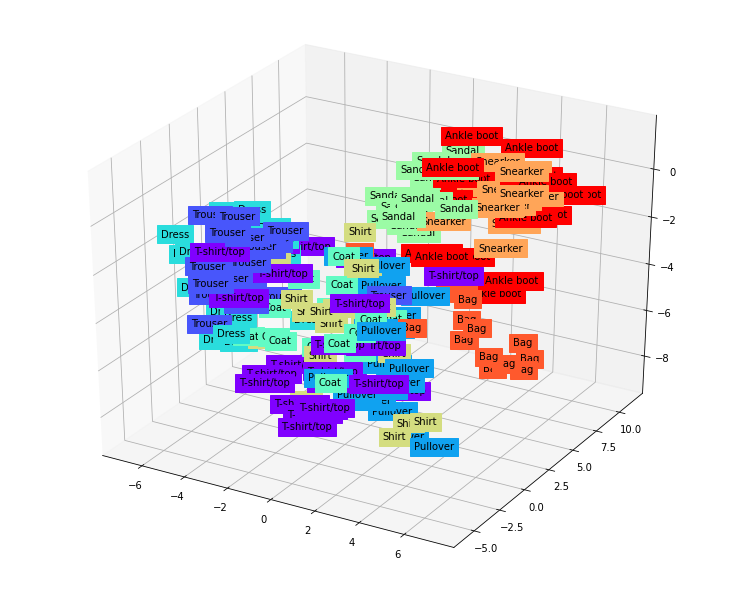

In [ ]:
fig=plt.figure(figsize=(10,8))
ax=Axes3D(fig)

X=encoded_data.data[:,0].numpy()
Y=encoded_data.data[:,1].numpy()
Z=encoded_data.data[:,2].numpy()

labels=trainset.train_labels[:200].numpy()

for x,y,z,s in zip(X,Y,Z,labels):
    name=CLASSES[s]
    color=cm.rainbow(int(255*s/9))
    ax.text(x,y,z,name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())

plt.show()

In [ ]:
#잡음 추가
def add_noise(img):
    noise=torch.randn(img.size())*0.2
    noisy_img=img+noise
    return noisy_img

In [ ]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss=0

    for step, (x, label) in enumerate(train_loader):
        x=add_noise(x) #입력에 노이즈 더하기
        x=x.view(-1, 28*28).to(DEVICE)
        y=x.view(-1, 28*28).to(DEVICE)
        label=label.to(DEVICE)

        encoded, decoded=autoencoder(x)

        loss=criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss+=loss.item()

    return avg_loss/len(train_loader)

In [ ]:
for i in range(1,EPOCH+1):
    loss=train(autoencoder, train_loader)
    print("[EPOCH {}] loss:{}".format(epoch, loss))

[EPOCH 10] loss:0.062492637360877575
[EPOCH 10] loss:0.0621320049780836
[EPOCH 10] loss:0.06203112429154834
[EPOCH 10] loss:0.06185206307022811
[EPOCH 10] loss:0.061780632797207656
[EPOCH 10] loss:0.06191640954091351
[EPOCH 10] loss:0.06170912249796172
[EPOCH 10] loss:0.06158797687956138
[EPOCH 10] loss:0.06166243732674544
[EPOCH 10] loss:0.06162714497891189


In [ ]:
testset=datasets.FashionMNIST(
    root='./.data/',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [ ]:
sample_data=testset.data[0].view(-1, 28*28)
sample_data=sample_data.type(torch.FloatTensor)/255.

In [ ]:
original_x=sample_data[0]
noisy_x=add_noise(original_x).to(DEVICE)
_, recovered_x=autoencoder(noisy_x)

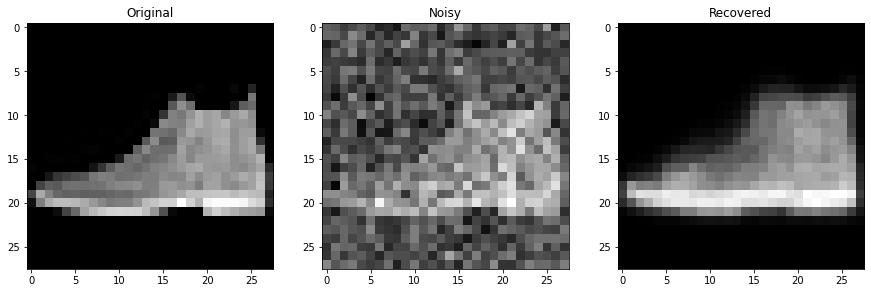

In [ ]:
f, a=plt.subplots(1,3,figsize=(15,15))

original_img=np.reshape(original_x.to("cpu").data.numpy(), (28,28))
noisy_img=np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img=np.reshape(recovered_x.to("cpu").data.numpy(), (28,28))

a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()